# Applying SDG labels to publications

This script makes use of the Open SDG project (https://osdg.ai/) and (https://github.com/osdg-ai/osdg-tool/tree/pre-release) to determine which SDG labels should be applied to publications based on the title + abstract. 

This notebook requires that a OpenSDG docker image is running somewhere. There is currently (2021-11-29) one running on the docker-dev machine and has port 5001 mapped to the correct container port.


In [1]:
import requests
import pandas as pd

In [2]:
osdg_url = 'http://docker-dev.vliz.be:5001/tag'
# The datafile that contains the publication information. 
data_file = 'lifewatch_pubs_20211004.xlsx'

### Get the labels from the server

In [3]:
def get_sdg(row):
    '''
    This function takes a pandas row and returns the same row with two additional columns. The "status" row is
    generally used for the http status of the request (I think) and the "result" row contains a dict 
    of <SDG_#>:<relevance> that has values for all SDG numbers that score > 0 on the relevance. 
    '''
    text = str(row['StandardTitle']) + str(row['AbstractEnglish'])
    text_dict = {'text':text}
    try:
        response = requests.post(osdg_url, json=text_dict)
        result = response.json()
        row['result_status'] = result['status']
        row['result'] = {item['sdg']:item['relevance'] for item in result['result']}  
    except Exception as err:
        print('Something went wrong')
        row['result_status'] = 'nOK'
        row['result'] = [err]
    return row

In [4]:
df = pd.read_excel(data_file)

In [24]:
# Many of the rows in the file have duplicate Titles and Abstracts. The function to get labels seems pretty slow so 
# it benefits from having duplicates dropped. 
df = df.drop_duplicates(subset=['StandardTitle', 'AbstractEnglish'])
#
small_df = df 
# If you want to work with a smaller subset for testing then uncomment the following line.
#small_df = df.iloc[0:100]

In [2]:
small_df  = small_df.apply(lambda row: get_sdg(row), axis=1)
small_df

NameError: name 'small_df' is not defined

In [1]:
small_df.shape()

NameError: name 'small_df' is not defined

## Sorta Pivot to get the dict info into columns...
Currently the SDG labels are stored in a dict with the SDG# and relevance value. It would be better to have a bunch of columns with the values in there.

https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

And checking the histogram of the results might provide some indication on whether to have a cutoff on "relevance" 

<AxesSubplot:>

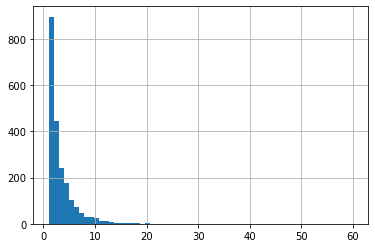

In [23]:
small_df.join(small_df['result'].apply(pd.Series))['SDG_2'].hist(bins=60)